In [1]:
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.multivariate_exponential_process import *
from functions.estimator_class_multi_rep import *
import scipy

In [2]:
np.random.seed(0)

### Simulation of a Marked Exponential Hawkes Process

We start by simulating a unidimensional Hawkes process denoted $N$. The intensity of the process is given by the formula: $\begin{equation} \lambda(t) = m + \int_{(-\infty ,t)\times \mathcal{E} } a e^{-b(t-s)} \phi_{\gamma, \psi}(\kappa) N(ds \times d\kappa), \end{equation}$


with $\kappa$ being an i.i.d. random variable with a c.d.f. $F_\psi$, admitting a density $f_\psi$.

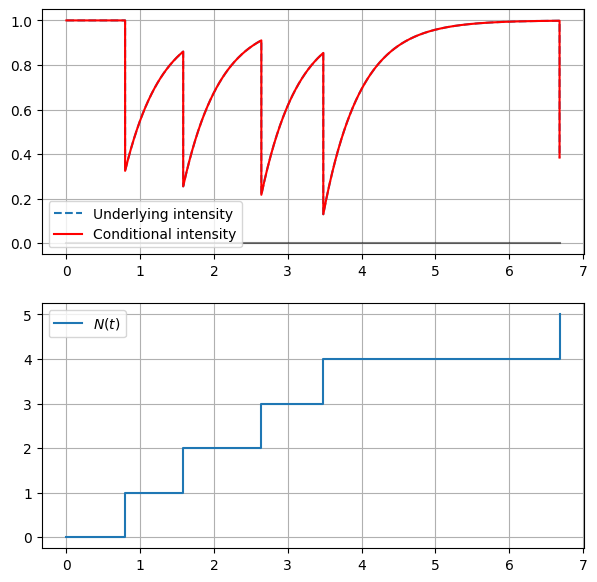

In [3]:

np.random.seed(0)

m, a, b = 1, -1, 2

## taking kappa i.i.d following a exponential distribution of parameter 1
def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))


hawkes = exp_thinning_hawkes_marked(m=m,
                                    a=a, 
                                    b=b, 
                                    F = F ,
                                    arg_F = {'psi':2},
                                    phi=phi, 
                                    arg_phi = {'gamma': 1},
                                    max_jumps = 5 )


hawkes.simulate()

fig, ax = plt.subplots(2,1, figsize=(7,7))
hawkes.plot_intensity(ax =ax)

fig.savefig('plot/simulation_MEHP.png')

We now consider a multidimensional Hawkes process for which the intensity $\lambda_i$ of the i-th subprocess takes the form: $\begin{equation} \lambda_{i}(t) = m_i + \sum_{j=1}^{d} \int_{(-\infty ,t)\times \mathcal{E}} a_{ij} e^{-b_i(t-s)} \phi_{\gamma, \psi}(\kappa) N^j(ds \times d\kappa), \end{equation}$

with $\kappa$ being an i.i.d. random variable with a c.d.f. $F_\psi$, admitting a density $f_\psi$.

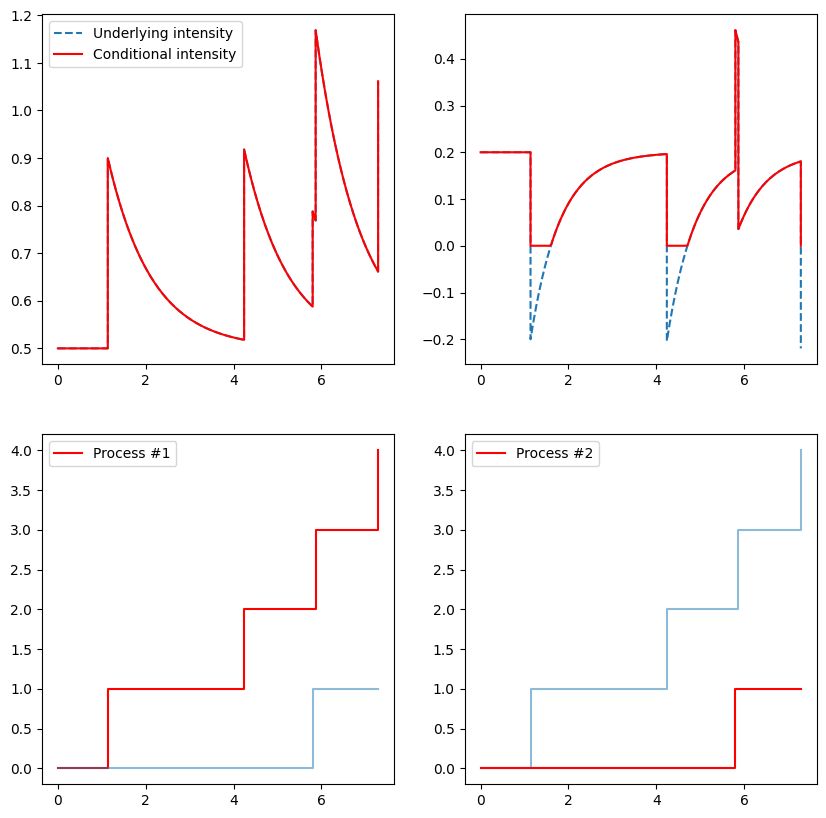

In [4]:
np.random.seed(0)

m = np.array([0.5, 0.2]).reshape((2,1))
a = np.array([[0.4, 0.2,], 
                  [-0.4, 0.3]] )
b = np.array([[1],[1.5]])


Tmax = 10
phi_arg = 0.5

def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))


hawkes_multi = multivariate_exponential_hawkes_marked(m=m,
                                                      a=a, 
                                                      b=b, 
                                                      phi = phi, 
                                                      F= F, 
                                                      arg_phi={'gamma':1}, 
                                                      arg_F={'psi': 2}, 
                                                      max_jumps  = 5)

hawkes_multi.simulate()

fig,ax = plt.subplots(2,2, figsize = (10,10))
hawkes_multi.plot_intensity(ax = ax)

In [276]:
def F(mark,time,psi):
    return(-1/psi*np.log(1-mark))


def F(mark,time, psi):
    return(1-np.exp(-psi*mark))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))


def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))



# Apply testing procedure on several samples

We present here the code used to apply different test procedures on a Hawkes process. To that end, we start by simulating a synthetic dataset containing 500 repetitions of a Hawkes process.

In [77]:
np.random.seed(0)

m=1
a = -1
b = 1

## simulation 
hawkes_multi = exp_thinning_hawkes_multi_marked(m=m,
                                    a=a, 
                                    b=b, 
                                    n=200,
                                    max_jumps=500)
hawkes_multi.simulate()

In [79]:
print(f'Correspond to Tmax = {np.mean([x[-1] for x in hawkes_multi.timeList])}')

Correspond to Tmax = 973.9496828617106


## Test on the coefficients of the model

### Test of a specific value for one coefficient

In [80]:
learner_hawkes = estimator_unidim_multi_rep(a_bound = None,
                                            bound_b = None)
learner_hawkes.fit(hawkes_multi.timeList, max_jump = True)

array([ 1.01121055, -1.02280361,  1.0061937 ])

Hypothesis under test: $\mathcal{H}_0 : m = 1 \quad \text{ vs } \quad \mathcal{H}_1 : m \ne 1$.

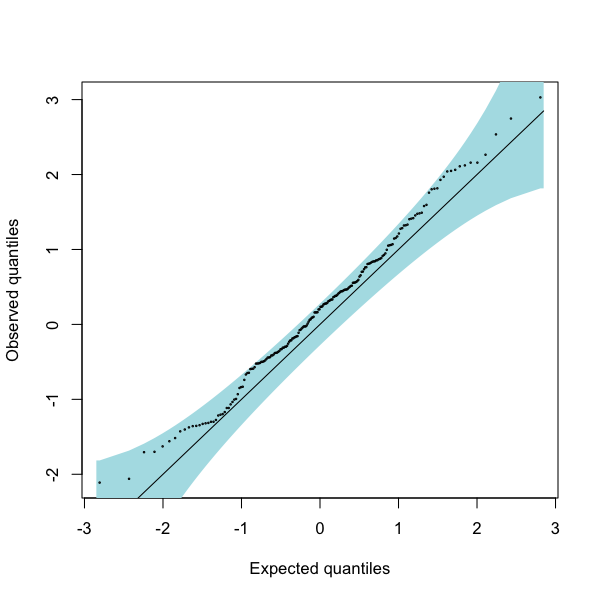

In [81]:
stat = learner_hawkes.test_one_coeff( coefficient_index=0, value = 1,plot=True)

Hypothesis under test: $\mathcal{H}_0 : a = -1 \quad \text{ vs } \quad \mathcal{H}_1 : a \ne -1$.

No theoretical garantee associated to this test


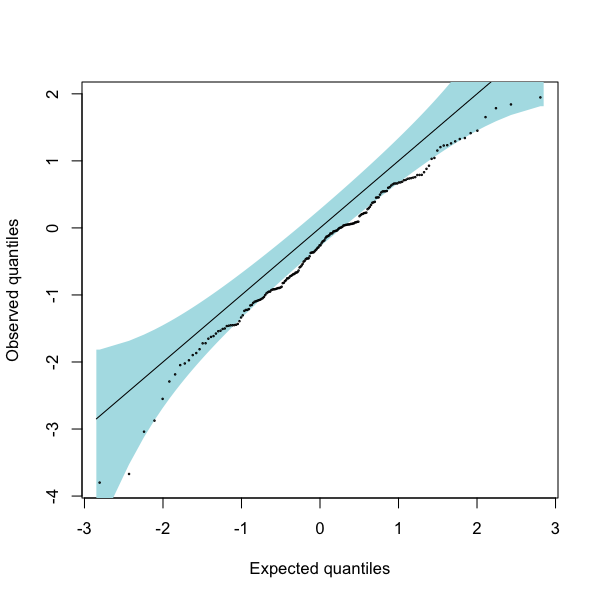

In [82]:
stat = learner_hawkes.test_one_coeff(coefficient_index=1,value=-1, plot = True)  

### Test of equality between coefficients 

Hypothesis under test: $\mathcal{H}_0 : a = m \quad \text{ vs } \quad \mathcal{H}_1 : a \ne m$.

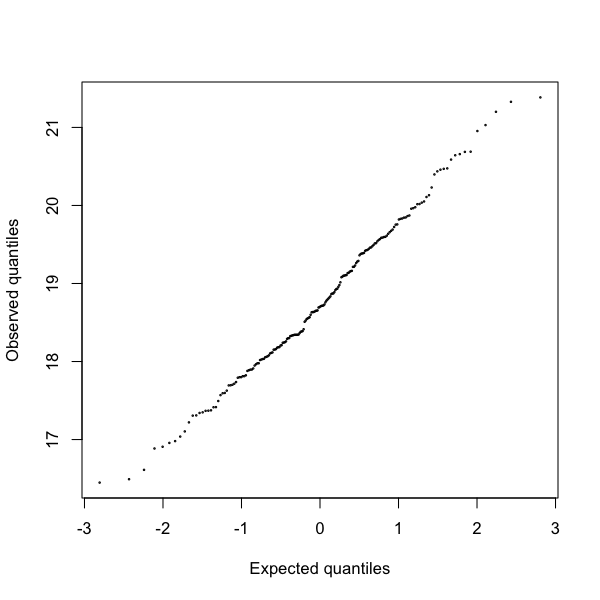

In [84]:
stat = learner_hawkes.test_equality_coeff(coefficient_index_1=0,coefficient_index_2=1)

## Test on the model used for estimation
We present here different tests on the model associated with the data, relying on the GOF procedure.

### Test of the self-exciting qssumption

Hypothesis under test: $\mathcal{H}_0 : \text{Data are i.i.d. representations of a Poisson model with an unknown parameter}$

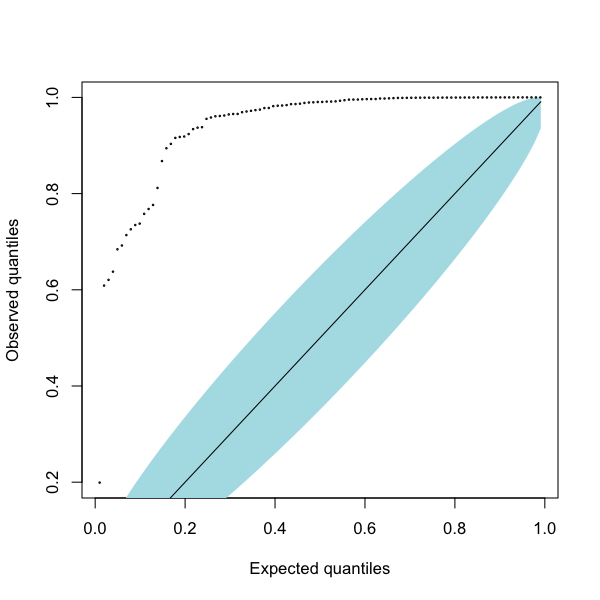

In [47]:
## Simulation done with Hawkes process with inhibition and test performed for a Poisson process

learner_poisson = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_poisson.fit(hawkes_multi.timeList,max_jump = True)
stats_poisson = learner_poisson.GOF_bootstrap(compensator_func=poisson_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=100, 
                                              plot = True)

We compare this result to the one obtain when testing the following null hypothesis. 
 $$\mathcal{H}_0 : \text{data are i.i.d represetation of a Hawkes model } $$

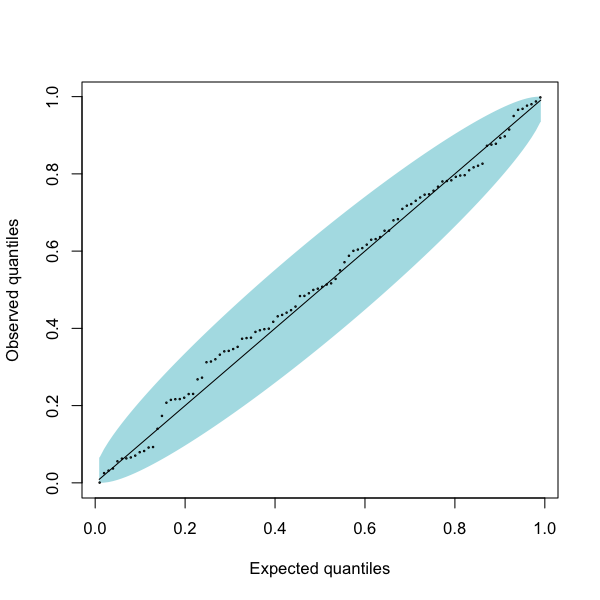

In [85]:
## Simulation done with Hawkes process with inhibition and test performed for a Hawkes process

stat_hawkes = learner_hawkes.GOF_bootstrap(test_type = 'uniform', 
                            Nb_SubSample=100, 
                            plot = True)

### Test of the inhibition assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a Hawkes model inhibition} $$

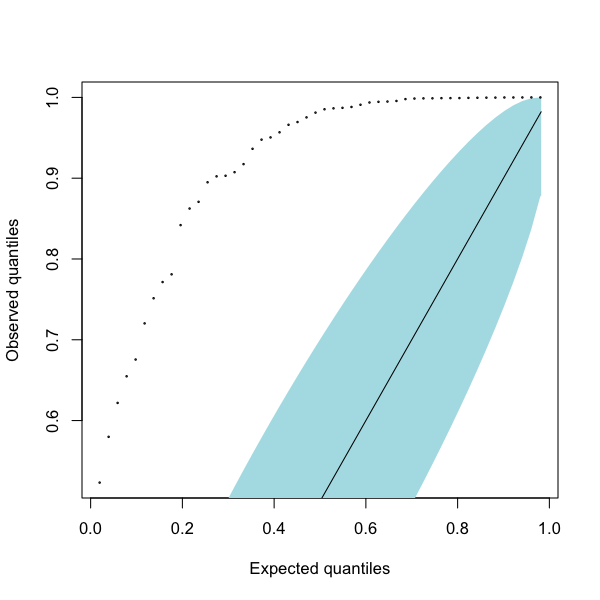

In [86]:
## Simulation done with Hawkes process with inhibition and test performed for a Hawkes process without inhibition

learner_hawkes_ex = estimator_unidim_multi_rep(a_bound=0)
learner_hawkes_ex.fit(hawkes_multi.timeList , max_jump = True)
stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap(compensator_func=unidim_EHP_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=50, 
                                              plot = True)

### Test of the marked assumpation

We test here the null hypothesis :  $$\mathcal{H}_0 : \text{data are i.i.d represetation of a marked Hawkes model} $$

In [19]:
m,a,b = 1, -1, 2

from functions.paramtrised_function import *


hawkes = exp_thinning_hawkes_multi_marked(m=m,
                                        a=a, 
                                        b=b, 
                                        mark_process=True,
                                        F=F1, 
                                        arg_F={'psi':2}, 
                                        phi=phi, 
                                        arg_phi={'gamma':1}, 
                                        max_jumps=500, 
                                        n=200)
hawkes.simulate()

learner = estimator_unidim_multi_rep(mark=True, 
                                     f=f, 
                                    name_arg_f=['psi'], 
                                    phi=phi, 
                                    name_arg_phi=['gamma'], 
                                    bound_f=[(1e-5, None)], 
                                    bound_phi=[(None,None)], 
                                    initial_guess_f=[1], 
                                    initial_guess_phi=[0])

learner.fit(hawkes.timeList)


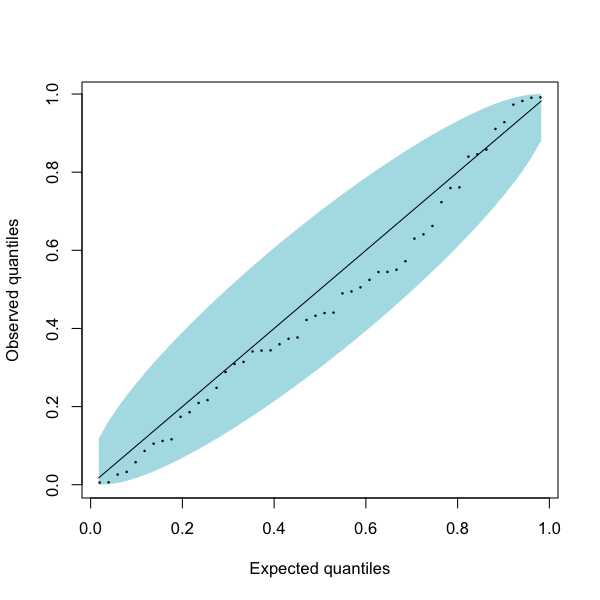

In [22]:
stats_hawkes_ex = learner.GOF_bootstrap(compensator_func=unidim_MEHP_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=50, 
                                              plot = True)

# Apply test when one repetition is available

Univariate case: 

In [1]:
### generation of a hawkes process with one repetition 
from functions.estimator_class import *
from functions.hawkes_process import *

np.random.seed(0)

m, a, b = 1, 0.5, 1

hawkes = exp_thinning_hawkes_marked(m=m,
                                    a=a, 
                                    b=b,
                                    max_time=2000 
                                    )
hawkes.simulate()

In [2]:
estimator = loglikelihood_estimator()
estimator.fit(hawkes.timestamps, max_time=True)
estimator.test_one_coeff(coefficient_index = 0
                         ,value= 1)

{'stat': np.float64(0.0947670559983569),
 'pval': np.float64(0.9244998545750325),
 'results': 0}

Multivariate case: 

In [7]:
from functions.multivariate_exponential_process import *
from functions.estimator_class import *

np.random.seed(0)

m = np.array([0.5, 0.2]).reshape((2,1))
a = np.array([[0.4, 0.2,], 
                  [0.4, 0.3]] )
b = np.array([[1],[1]])



hawkes_multi = multivariate_exponential_hawkes(m=m,
                                                      a=a, 
                                                      b=b, 
                                                      max_jumps  = 1000)

hawkes_multi.simulate()

In [8]:
estimator = multivariate_estimator(dimension=2)
estimator.fit(hawkes_multi.timestamps, max_jump=True)


In [6]:
estimator.test_equality_coeff(coefficient_index_1 =7,coefficient_index_2=6)

{'stat': np.float64(1.603890121000154),
 'pval': np.float64(0.10873827477676934)}

# Real dataset

In [114]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [116]:
df = pd.read_csv('data/earthquake.txt')

### Stationnarity study

We try here to find a scale at wich the process seem stationnary. To that end we start by displaying the number of event happening per day / month / year. 

In [117]:
format='%Y-%m-%d %H:%M:%S'

df['datetime'] =df['date'].apply(lambda x : datetime.datetime.strptime(x[:19], format))
df['month'] = df['datetime'].apply(lambda x : (int(x.year)-1990)*12 + int(x.month) )
df['day'] = df['datetime'].apply(lambda x :(datetime.date(x.year, x.month, x.day) - datetime.date(1990, 1, 1)).days )
df['year'] = df['datetime'].apply(lambda x : x.year)


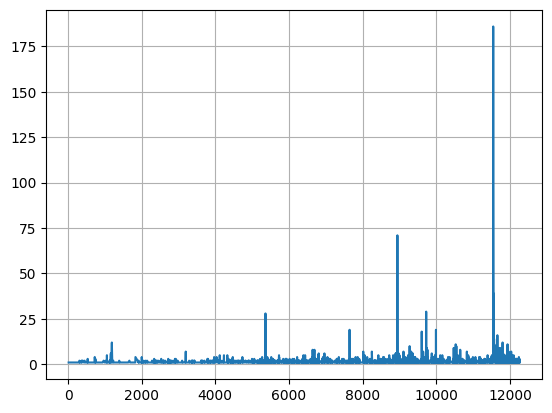

In [26]:
window = len(df)
start = 0


data_month = df.groupby('day').apply(len,include_groups=False).reset_index(name='nb_event')

plt.figure()
plt.clf()
plt.plot(data_month['day'].tolist()[start : start+window], data_month['nb_event'].tolist()[start : start+window])

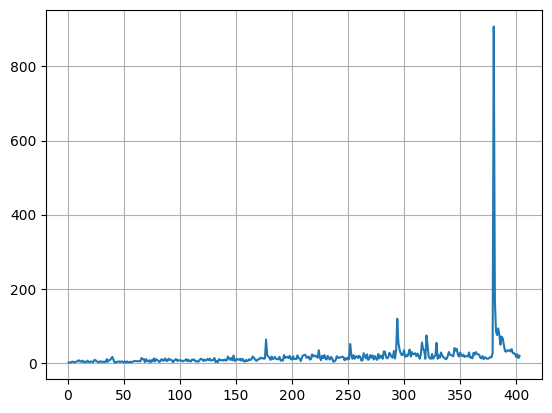

In [27]:
data_month = df.groupby('month').apply(len,include_groups=False).reset_index(name='nb_event')

plt.figure()
plt.clf()
plt.plot(data_month['month'].tolist(), data_month['nb_event'].tolist())

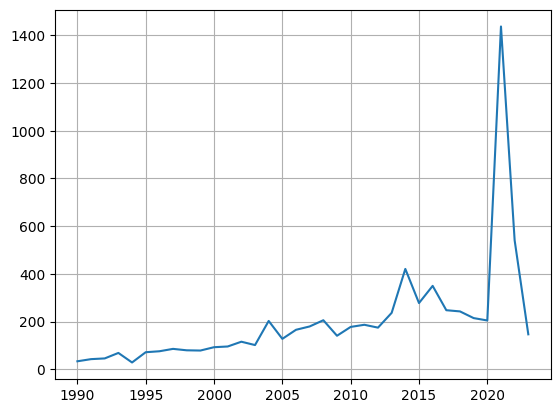

In [28]:
data_month = df.groupby('year').apply(len,include_groups=False).reset_index(name='nb_event')

plt.figure()
plt.clf()
plt.plot(data_month['year'].tolist(), data_month['nb_event'].tolist())

Based on the previous graphs, we have chosen the day as the unit of measurement. As a result, we convert the process and the associated differences into days. We are now looking for time periods that will serve as repetitions. The goal is to find periods long enough to achieve stationarity and to ensure that at the end and beginning of each period, the process returns to its baseline intensity.

In [29]:
scale = 60*60*24

df['day_diff'] = df['datetime'].apply(lambda x : (x-datetime.datetime(1990, 1,1, 0,0,0)).total_seconds()/scale )

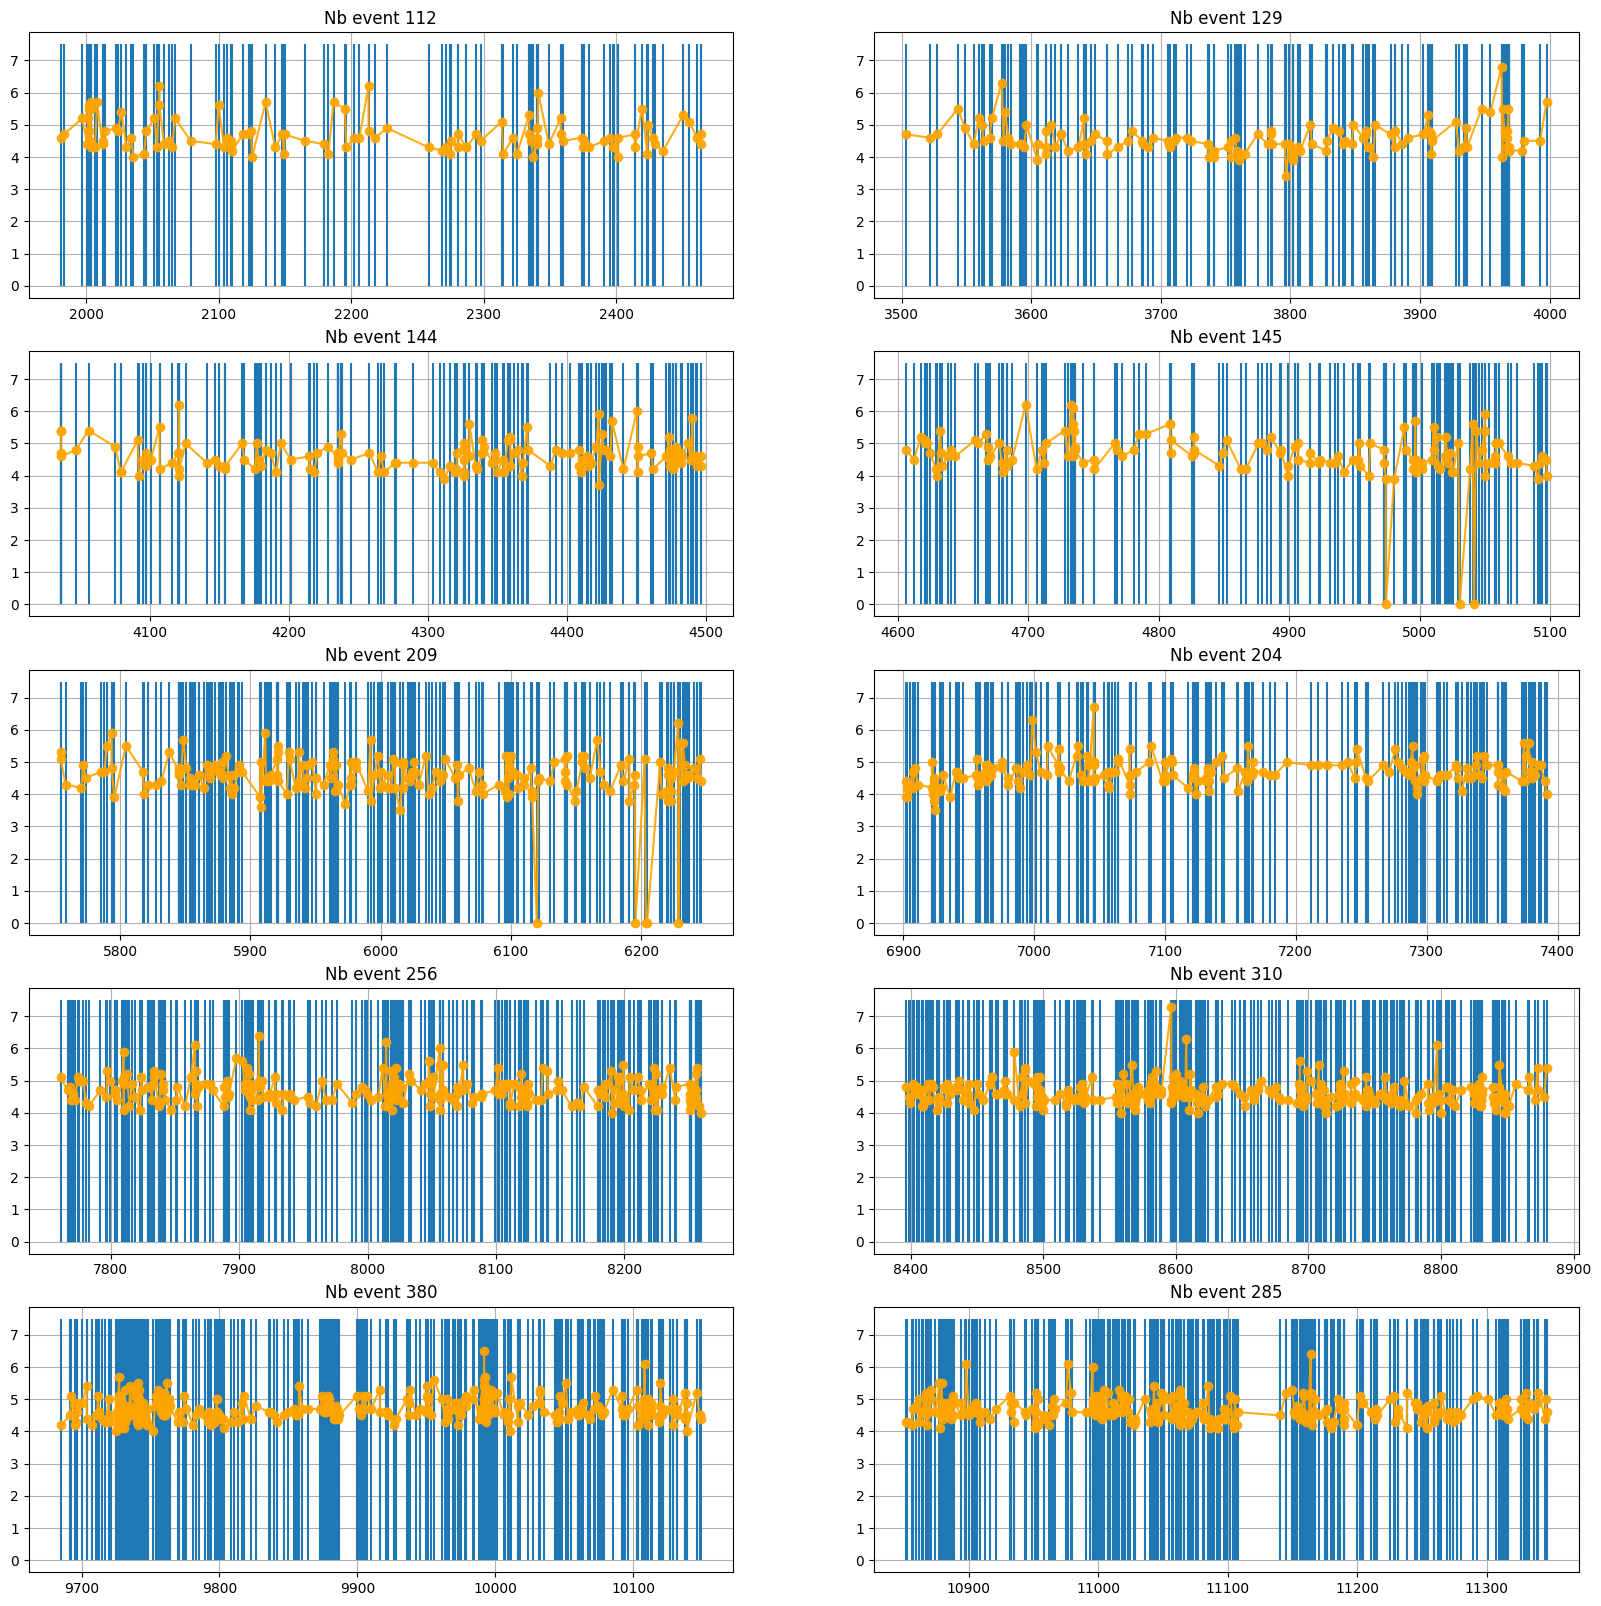

In [76]:
period = np.array([ [1980, 2480], [3500, 4000], [4000,4500], [4600,5100], [5750, 6250], [6900, 7400], [7760, 8260], [8380, 8880], [9680, 10150], [10850,11350]])

fix, ax = plt.subplots( 5,2 , figsize=(20,20))

for k in range(10):
    i,j = k // 2, k%2
    selected_event = df.loc[ (df.day_diff<=period[k,1]) &  (period[k,0] <= df.day_diff), : ]
    ax[i,j].vlines(selected_event['day_diff'].tolist(), ymin=0, ymax=7.5)
    ax[i,j].set_title(f'Nb event {len(selected_event)}')
    ax[i,j].plot( selected_event['day_diff'].tolist() , selected_event['magnitudo'].tolist(), color='orange', marker='o',alpha = 0.9)


In [61]:
## test Hawkes

tlist,tlist_marked = [],[]
for k in range(len(period)):
    selected_period = df.loc[ (df.day_diff<=period[k,1]) &  (period[k,0] <= df.day_diff),['day_diff', 'magnitudo']]
    selected_period['day_diff'] = selected_period['day_diff'] - period[k,0]
    
    tlist_marked +=  [[(0,0)] +list(selected_period.itertuples(index=False, name = None))+ [(500, 0)]]
    tlist +=  [[0] +list(selected_period.loc[:,'day_diff'].tolist())+ [500]]


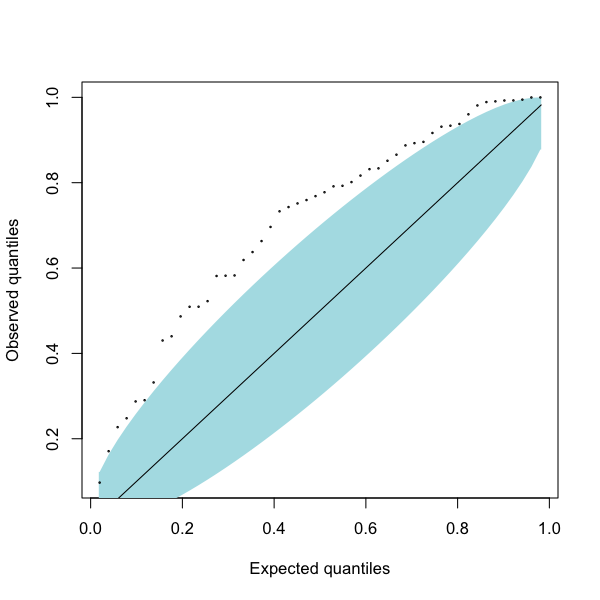

In [72]:
from functions.paramtrised_function import f, phi1

learner_marked_hawkes = estimator_unidim_multi_rep(mark = True, 
                                                        f = f, 
                                                        phi = phi1, 
                                                        name_arg_f=['psi'], 
                                                        name_arg_phi=['gamma'], 
                                                        initial_guess_phi=[0], 
                                                        initial_guess_f=[1],
                                                        bound_f=[(0.01,None)], 
                                                        bound_phi=[(0,None)])

learner_marked_hawkes.fit(tlist_marked, max_time=True)
pvals= learner_marked_hawkes.GOF_bootstrap(compensator_func=unidim_MEHP_compensator)
    

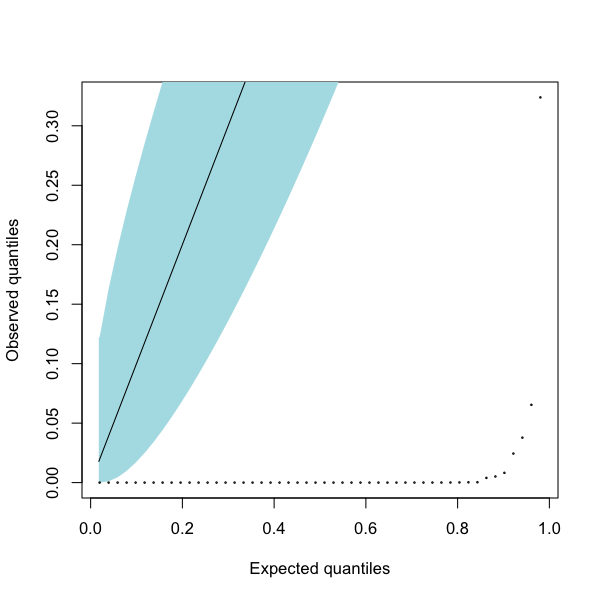

In [73]:
learner_hawkes = estimator_unidim_multi_rep()
learner_hawkes.fit(tlist)
pvals =learner_hawkes.GOF_bootstrap(compensator_func=unidim_EHP_compensator)

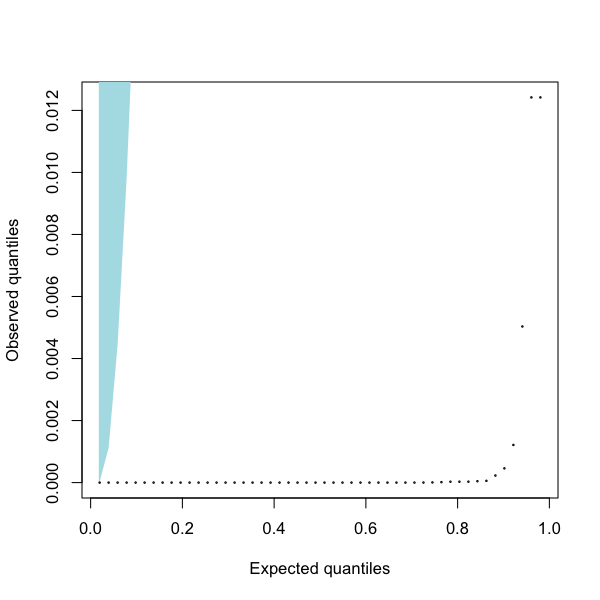

In [74]:
learner_marked_hawkes = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_marked_hawkes.fit(tlist)
pvals =learner_marked_hawkes.GOF_bootstrap(compensator_func=poisson_compensator)